In [107]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os
import warnings
import scipy
import scipy.signal
import scipy.optimize
import scipy.constants
import cv2

import uncertainties as uc
import uncertainties.unumpy as unumpy

from sklearn.metrics import r2_score


In [108]:
def list_hdf5_files(start_path):
    hdf5_files = []
    for root, dirs, files in os.walk(start_path):
        for file in files:
            if file.endswith('.hdf5'):
                hdf5_files.append(os.path.join(root, file))
    return hdf5_files

def load_csv_files(hdf5_path):
    path = os.path.dirname(hdf5_path)
    data = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.csv'):
                data.append(np.loadtxt(os.path.join(root, file), skiprows=1, delimiter=","))

    return data


def moving_average(data, window_size):   
    extended_data = np.concatenate([data, data[:window_size-1]])  # Extend the data for wrapping
    return np.convolve(extended_data, np.ones(window_size), 'valid')[:len(data)] / window_size

def param_cos(x, a, b, c, d):
    if a < 0:
        return np.zeros(x.shape)
    
    return a * np.sqrt(np.abs(np.cos(b * (x - c)))) + d

def clamp_to_closest(upper, lower):
    closest_indices = np.abs(upper[:, None] - lower).argmin(axis=0)
    return upper[closest_indices]

In [109]:
data_dir = "qubit voltage sweep"
DATA_ROOT = "data"

path = os.path.join(DATA_ROOT, data_dir)

hdf5_files = list_hdf5_files(path)
hdf5_files

['data\\qubit voltage sweep\\000140_QubitSpectroscopy_continuous_qb1\\000140_QubitSpectroscopy_continuous_qb1.hdf5',
 'data\\qubit voltage sweep\\113301_QubitSpectroscopy_continuous_qb1\\113301_QubitSpectroscopy_continuous_qb1.hdf5',
 'data\\qubit voltage sweep\\142720_QubitSpectroscopy_continuous_qb1\\142720_QubitSpectroscopy_continuous_qb1.hdf5',
 'data\\qubit voltage sweep\\145526_QubitSpectroscopy_continuous_qb1\\145526_QubitSpectroscopy_continuous_qb1.hdf5']

In [110]:
f = h5py.File(hdf5_files[3])
data = np.array(list(f["Experimental Data"]["Data"]))
freqs = np.array(list(f["Experimental Data"]["Experimental Metadata"]["task_list"]["list_idx_0"]["freqs"])) * 1e-9
volts = np.array(list(f["Experimental Data"]["Experimental Metadata"]["task_list"]["list_idx_0"]["volts"]))

if len(data) != len(freqs) * len(volts):
    warnings.warn("The dataset doesn't seem to be complete")
    data = np.zeros((len(freqs) * len(volts), 4))
    temp = np.array(list(f["Experimental Data"]["Data"]))
    data[:len(temp)] = temp
    data[len(temp):] = np.min(temp)

initial_guesses = load_csv_files(hdf5_files[3])
print(volts)
for i in initial_guesses:
    i[:,1] = clamp_to_closest(volts, i[:,1]) 

[-6.00000000e+00 -5.80000000e+00 -5.60000000e+00 -5.40000000e+00
 -5.20000000e+00 -5.00000000e+00 -4.80000000e+00 -4.60000000e+00
 -4.40000000e+00 -4.20000000e+00 -4.00000000e+00 -3.80000000e+00
 -3.60000000e+00 -3.40000000e+00 -3.20000000e+00 -3.00000000e+00
 -2.80000000e+00 -2.60000000e+00 -2.40000000e+00 -2.20000000e+00
 -2.00000000e+00 -1.80000000e+00 -1.60000000e+00 -1.40000000e+00
 -1.20000000e+00 -1.00000000e+00 -8.00000000e-01 -6.00000000e-01
 -4.00000000e-01 -2.00000000e-01  5.32907052e-15  2.00000000e-01
  4.00000000e-01  6.00000000e-01  8.00000000e-01]


In [111]:
y = np.abs(data[:,2] + 1j * data[:,3])
y = np.reshape(y, (len(volts), len(freqs)))
y = np.flipud(y)

In [112]:
def get_local_peaks_with_guess(guess, delta = 0.05, debug = False):
    epsilon = np.abs(volts[0] - volts[1])/4
    delta_i = int(delta / np.abs(freqs[0] - freqs[1]))
    all_ind = []

    guess[:, 1] = guess[:, 1] + np.abs(volts[0] - volts[1])

    for i, k in enumerate(y):
        mask = np.abs(guess[:,1] - volts[i]) < epsilon
        contained_in_guess = np.count_nonzero(mask)
        index = np.argmax(mask)
        if contained_in_guess >= 2:
            print("What the actual fuck please help me")
            return
        if contained_in_guess == 0:
            continue

        freq_index = np.argmin(np.abs(freqs - guess[index, 0]))
        
        lower = max(0, freq_index - delta_i)
        upper = min(len(freqs), delta_i + freq_index)
        window = k[lower:upper]
        min_f = np.argmin(window) + max(0, freq_index - delta_i)

        all_ind.append([freqs[min_f], guess[index, 1]])

        if debug:
            plt.plot(freqs, k)
            plt.title(f"{guess[index, 1]:.1f}")
            plt.axvline(freqs[lower])
            plt.axvline(freqs[upper])
            plt.axvline(freqs[freq_index], color="orange")
            plt.axvline(guess[index, 0], color="red")
            plt.axvline(freqs[min_f], color="green")
            plt.show()
            plt.close()
     
    guess[:, 1] = guess[:, 1] - np.abs(volts[0] - volts[1])
    all_ind = np.array(all_ind)
    all_ind[:, 1] = all_ind[:, 1] - np.abs(volts[0] - volts[1])
    return all_ind
        
point = get_local_peaks_with_guess(initial_guesses[2], 0.05)


30
67+/-4
17
681+/-24
29
79+/-5
10
(1.98+/-0.13)e+03


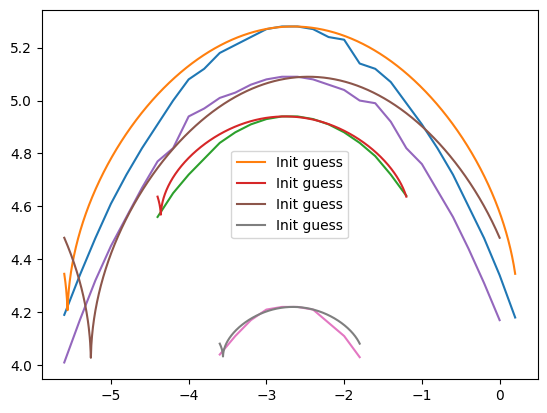

In [113]:
offsets = np.array([0, 0.5, 0, 1.4])
for i, init in enumerate(initial_guesses):
    print(len(init))
    p = get_local_peaks_with_guess(init, 0.05)
    p0 = [np.max(p[:,0]) - np.min(p[:,0]), 
          np.pi /(np.max(p[:,1]) - np.min(p[:,1])), np.pi + offsets[i], np.min(p[:,0])]
    plt.plot(p[:,1],p[:,0])
    params, cov = scipy.optimize.curve_fit(param_cos, p[:,1], p[:,0], p0, maxfev = 10000000)
    _x = np.linspace(np.min(p[:,1]), np.max(p[:,1]), 1900)
    plt.plot(_x, param_cos(_x, *p0), label="Init guess")
    plt.legend()

    cov = np.sqrt(np.diag(cov))
    par = unumpy.uarray(params, cov)
    E_C = -par[3] * scipy.constants.hbar
    E_J = -par[0]**2 * scipy.constants.hbar/(8 * par[3])
    print(E_C/E_J)
    #plt.plot(_x, param_cos(_x, *params))
    #plt.show()
    #plt.close()


In [114]:
g = initial_guesses[0]
print(len(g))
p = get_local_peaks_with_guess(g, 0.05)
p0 = [np.max(p[:,0]) - np.min(p[:,0]), 
          np.pi /(np.max(p[:,1]) - np.min(p[:,1])), np.pi + offsets[0], np.min(p[:,0])]
params, cov = scipy.optimize.curve_fit(param_cos, p[:,1], p[:,0], p0, maxfev = 10000000)

30


In [115]:
freqs[0] - freqs[1]

-0.010000000000000675

67+/-4
(-6.11+/-0.35)e-27
(-4.111+/-0.033)e-25
681+/-24
(-6.89+/-0.24)e-28
(-4.696+/-0.007)e-25
79+/-5
(-5.16+/-0.30)e-27
(-4.064+/-0.029)e-25
(1.98+/-0.13)e+03
(-2.11+/-0.14)e-28
(-4.188+/-0.007)e-25


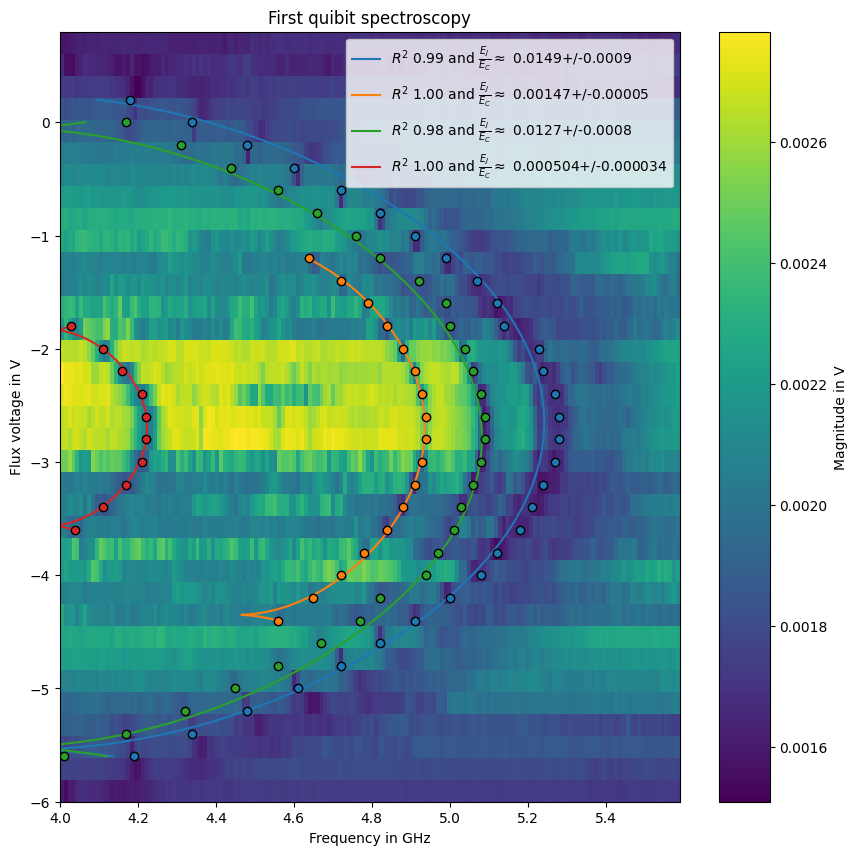

In [116]:
plt.figure(figsize=(10, 10))
offsets = np.array([0, 0.5, 0, 1.4])
for i, init in enumerate(initial_guesses):
    p = get_local_peaks_with_guess(init, 0.05)
    p0 = [np.max(p[:,0]) - np.min(p[:,0]), 
          np.pi /(np.max(p[:,1]) - np.min(p[:,1])), np.pi + offsets[i], np.min(p[:,0])]
    plt.scatter(p[:,0],p[:,1], marker="o", zorder=100, edgecolor="black")
    params, cov = scipy.optimize.curve_fit(param_cos, p[:,1], p[:,0], p0, maxfev = 10000000)
    _x = np.linspace(np.min(p[:,1]), np.max(p[:,1]), 1900)
    cov = np.diag(cov)
    stuffs = unumpy.uarray(params, np.sqrt(cov))
    
    E_C = -stuffs[3] * scipy.constants.hbar * 1e9
    E_J = -stuffs[0]**2 * scipy.constants.hbar/(8 * stuffs[3]) * 1e9
    plt.plot(param_cos(_x, *params), _x, label=f"$R^2$ {(r2_score(p[:,0], param_cos(p[:,1], *params) )):.2f} and " + "$\\frac{E_J}{E_C}\\approx$ " + f"{E_J/E_C}")
    print(E_C/E_J)
    print(E_J)
    print(E_C)
    
    
#
im = plt.imshow(y, aspect='auto', extent=[np.min(freqs), np.max(freqs), np.min(volts), np.max(volts)])
plt.xlabel("Frequency in GHz")
plt.ylabel("Flux voltage in V")
col_bar = plt.colorbar(im, aspect=15)
plt.title("First quibit spectroscopy")
col_bar.set_label("Magnitude in V")
#plt.scatter(min_freq, volts, color="red", marker="x")
#plt.plot(param_cos(volts, a, b, c, d), volts, color="red")
plt.legend()
plt.savefig("rsc/qubit_spec1.pdf", bbox_inches="tight")
plt.show()

In [117]:
f = h5py.File(hdf5_files[0])
data = np.array(list(f["Experimental Data"]["Data"]))
freqs = np.array(list(f["Experimental Data"]["Experimental Metadata"]["task_list"]["list_idx_0"]["freqs"])) * 1e-9
volts = np.array(list(f["Experimental Data"]["Experimental Metadata"]["task_list"]["list_idx_0"]["volts"]))

if len(data) != len(freqs) * len(volts):
    warnings.warn("The dataset doesn't seem to be complete")
    data = np.zeros((len(freqs) * len(volts), 4))
    temp = np.array(list(f["Experimental Data"]["Data"]))
    data[:len(temp)] = temp
    data[len(temp):] = np.min(temp)

initial_guesses = load_csv_files(hdf5_files[3])
print(volts)
for i in initial_guesses:
    i[:,1] = clamp_to_closest(volts, i[:,1]) 

[-6.00000000e+00 -5.90000000e+00 -5.80000000e+00 -5.70000000e+00
 -5.60000000e+00 -5.50000000e+00 -5.40000000e+00 -5.30000000e+00
 -5.20000000e+00 -5.10000000e+00 -5.00000000e+00 -4.90000000e+00
 -4.80000000e+00 -4.70000000e+00 -4.60000000e+00 -4.50000000e+00
 -4.40000000e+00 -4.30000000e+00 -4.20000000e+00 -4.10000000e+00
 -4.00000000e+00 -3.90000000e+00 -3.80000000e+00 -3.70000000e+00
 -3.60000000e+00 -3.50000000e+00 -3.40000000e+00 -3.30000000e+00
 -3.20000000e+00 -3.10000000e+00 -3.00000000e+00 -2.90000000e+00
 -2.80000000e+00 -2.70000000e+00 -2.60000000e+00 -2.50000000e+00
 -2.40000000e+00 -2.30000000e+00 -2.20000000e+00 -2.10000000e+00
 -2.00000000e+00 -1.90000000e+00 -1.80000000e+00 -1.70000000e+00
 -1.60000000e+00 -1.50000000e+00 -1.40000000e+00 -1.30000000e+00
 -1.20000000e+00 -1.10000000e+00 -1.00000000e+00 -9.00000000e-01
 -8.00000000e-01 -7.00000000e-01 -6.00000000e-01 -5.00000000e-01
 -4.00000000e-01 -3.00000000e-01 -2.00000000e-01 -1.00000000e-01
 -2.13162821e-14  1.00000

C:\Users\janlu\AppData\Local\Temp\ipykernel_11036\1838642067.py:7: UserWarning: The dataset doesn't seem to be complete
  warnings.warn("The dataset doesn't seem to be complete")


In [118]:
y = np.abs(data[:,2] + 1j * data[:,3])
y = np.reshape(y, (len(volts), len(freqs)))
y = np.flipud(y)

In [119]:
def get_local_peaks_with_guess(guess, delta = 0.05, debug = False):
    epsilon = np.abs(volts[0] - volts[1])/4
    delta_i = int(delta / np.abs(freqs[0] - freqs[1]))
    all_ind = []

    guess[:, 1] = guess[:, 1] + np.abs(volts[0] - volts[1])

    for i, k in enumerate(y):
        mask = np.abs(guess[:,1] - volts[i]) < epsilon
        contained_in_guess = np.count_nonzero(mask)
        index = np.argmax(mask)
        if contained_in_guess >= 2:
            print("What the actual fuck please help me")
            return
        if contained_in_guess == 0:
            continue

        freq_index = np.argmin(np.abs(freqs - guess[index, 0]))
        
        lower = max(0, freq_index - delta_i)
        upper = min(len(freqs), delta_i + freq_index)
        window = k[lower:upper]
        min_f = np.argmin(window) + max(0, freq_index - delta_i)

        all_ind.append([freqs[min_f], guess[index, 1]])

        if debug:
            plt.plot(freqs, k)
            plt.title(f"{guess[index, 1]:.1f}")
            plt.axvline(freqs[lower])
            plt.axvline(freqs[upper])
            plt.axvline(freqs[freq_index], color="orange")
            plt.axvline(guess[index, 0], color="red")
            plt.axvline(freqs[min_f], color="green")
            plt.show()
            plt.close()
     
    guess[:, 1] = guess[:, 1] - np.abs(volts[0] - volts[1])
    all_ind = np.array(all_ind)
    all_ind[:, 1] = all_ind[:, 1] - np.abs(volts[0] - volts[1])
    return all_ind
        
point = get_local_peaks_with_guess(initial_guesses[2], 0.05)


30
17
29
10


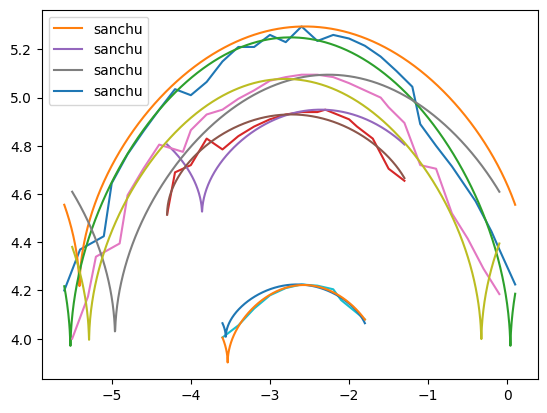

In [120]:
offsets = np.array([0, 0.5, 0, 1.4])
for i, init in enumerate(initial_guesses):
    print(len(init))
    p = get_local_peaks_with_guess(init, 0.05)
    p0 = [np.max(p[:,0]) - np.min(p[:,0]), 
          np.pi /(np.max(p[:,1]) - np.min(p[:,1])), np.pi + offsets[i], np.min(p[:,0])]
    plt.plot(p[:,1],p[:,0])
    params,_ = scipy.optimize.curve_fit(param_cos, p[:,1], p[:,0], p0, maxfev = 10000000)
    _x = np.linspace(np.min(p[:,1]), np.max(p[:,1]), 1900)
    plt.plot(_x, param_cos(_x, *p0), label="sanchu")
    plt.plot(_x, param_cos(_x, *params))
    plt.legend()
    #plt.show()
    #plt.close()


0.0137+/-0.0009
73+/-5
E_J \left(-5.69 \pm 0.35\right) \times 10^{-27}
E_C \left(-4.160 \pm 0.032\right) \times 10^{-25}
0.00106+/-0.00026
(9.4+/-2.3)e+02
E_J \left(-5.0 \pm 1.2\right) \times 10^{-28}
E_C \left(-4.76 \pm 0.05\right) \times 10^{-25}
0.0096+/-0.0015
105+/-16
E_J \left(-4.0 \pm 0.6\right) \times 10^{-27}
E_C \left(-4.19 \pm 0.07\right) \times 10^{-25}
0.00086+/-0.00007
(1.16+/-0.09)e+03
E_J \left(-3.54 \pm 0.28\right) \times 10^{-28}
E_C \left(-4.112 \pm 0.011\right) \times 10^{-25}


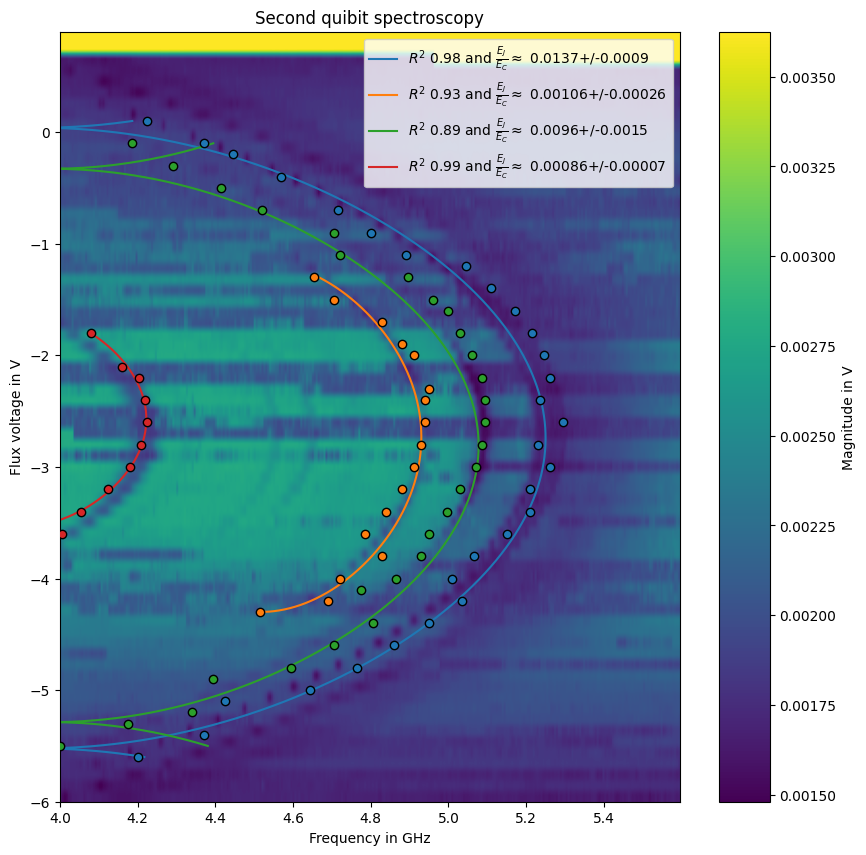

: 

In [121]:
plt.figure(figsize=(10, 10))
offsets = np.array([0, 0.5, 0, 1.4])
for i, init in enumerate(initial_guesses):
    p = get_local_peaks_with_guess(init, 0.05)
    p0 = [np.max(p[:,0]) - np.min(p[:,0]), 
          np.pi /(np.max(p[:,1]) - np.min(p[:,1])), np.pi + offsets[i], np.min(p[:,0])]
    plt.scatter(p[:,0],p[:,1], marker="o", zorder=100, edgecolor="black")
    params,cov = scipy.optimize.curve_fit(param_cos, p[:,1], p[:,0], p0, maxfev = 10000000)
    _x = np.linspace(np.min(p[:,1]), np.max(p[:,1]), 1900)
    

    cov = np.diag(cov)
    stuffs = unumpy.uarray(params, np.sqrt(cov))
    
    E_C = -stuffs[3] * scipy.constants.hbar * 1e9
    E_J = -(stuffs[0])**2 * scipy.constants.hbar/(8 * stuffs[3]) * 1e9
    plt.plot(param_cos(_x, *params), _x, label=f"$R^2$ {(r2_score(p[:,0], param_cos(p[:,1], *params) )):.2f} and " + "$\\frac{E_J}{E_C}\\approx$ " + f"{E_J/E_C}")
    print(E_J/E_C)
    print(E_C/E_J)
    print(f"E_J {E_J:L}")
    print(f"E_C {E_C:L}")

#
im = plt.imshow(y, aspect='auto', extent=[np.min(freqs), np.max(freqs), np.min(volts), np.max(volts)])
plt.xlabel("Frequency in GHz")
plt.ylabel("Flux voltage in V")
col_bar = plt.colorbar(im, aspect=15)
col_bar.set_label("Magnitude in V")
#plt.scatter(min_freq, volts, color="red", marker="x")
#plt.plot(param_cos(volts, a, b, c, d), volts, color="red")
plt.title("Second quibit spectroscopy")
plt.legend()
plt.savefig("rsc/qubit_spec2.pdf", bbox_inches="tight")
#plt.savefig("test.png", dpi=300)
plt.show()